In [2]:
#https://www.dummies.com/programming/python/plotting-a-sound-file-in-ipython/
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
import gurobipy
from IPython.display import Audio

Text(0.5, 1.0, 'wav_file1')

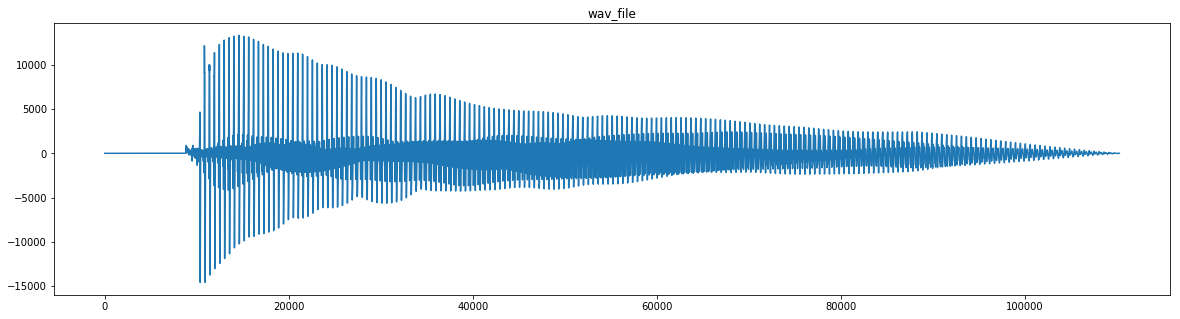

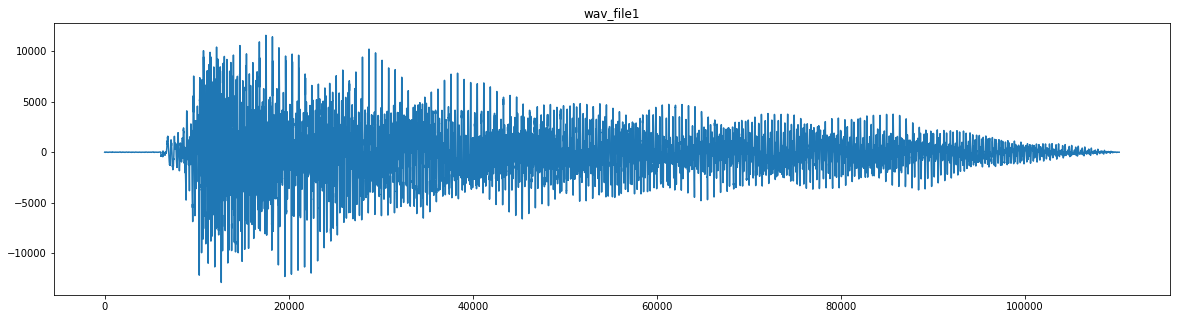

In [3]:
# Read WAV File
wav_file = 'audiofile/G53-40100-1111-235.wav'
rate, data = wav.read(wav_file)
file_length_in_seconds = len(data)/rate

wav_file1= 'audiofile/1-E1-Major 07.wav'
rate1, data1 = wav.read(wav_file1)
file_length_in_seconds1 = len(data1)/rate1

%matplotlib inline
plt.figure(figsize=(20,5))
plt.plot(data)
plt.title('wav_file')
#plt.show() #not needed if %matplotlib inline is already initialized
plt.figure(figsize=(20,5))
plt.plot(data1)
plt.title('wav_file1')

In [4]:
Audio(wav_file)

In [5]:
Audio(wav_file1)

## FFT

In [6]:
# Function for transforming a signal with fourier
def fourier_trans(data, rate, begin_time, end_time): 
    # initialising variables
    tp_count = len(data)
    values = np.arange(int(tp_count/2))
    time_period = tp_count/rate
    frequencies = values/time_period
    
    #at what intervals time points are sampled
    sampling_interval = 1/rate;
    
    #time points
    time = np.arange(begin_time, end_time, sampling_interval);
    
    #Frequency domain representation
    fourier_transform = fft(data)/tp_count #normalized the amplitude
    fourier_transform = fourier_transform[range(int(len(data)/2))] #exclude sampling frequency
    
    return frequencies, abs(fourier_transform)

In [7]:
freq, fourier = fourier_trans(data, rate, 0, file_length_in_seconds)

In [8]:
freq1, fourier1 = fourier_trans(data1, rate1, 0, file_length_in_seconds1)

In [9]:
# Frequency domain representation
def plot_freq_domain(freq, fourier,name):
    plt.figure(figsize=(20,5))
    plt.plot(freq, fourier)
    plt.xlabel('Frequency in Hz')
    plt.ylabel('Amplitude')
    plt.xlim(0, 1300)
    plt.title(name)
    plt.show()

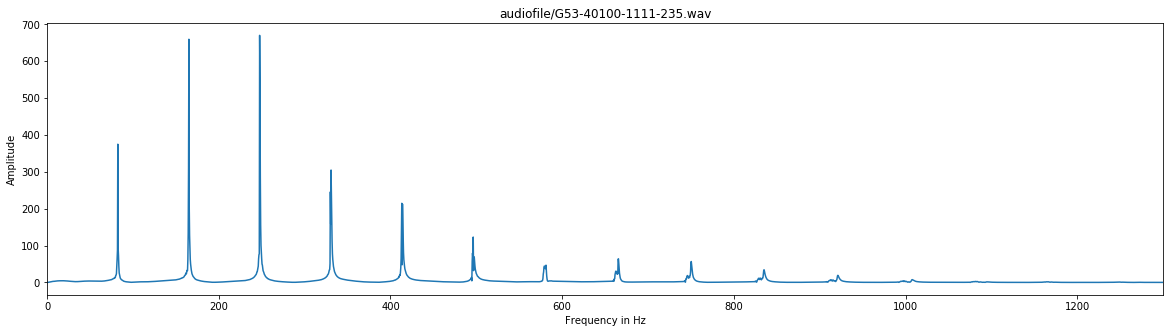

In [10]:
plot_freq_domain(freq,fourier, wav_file)

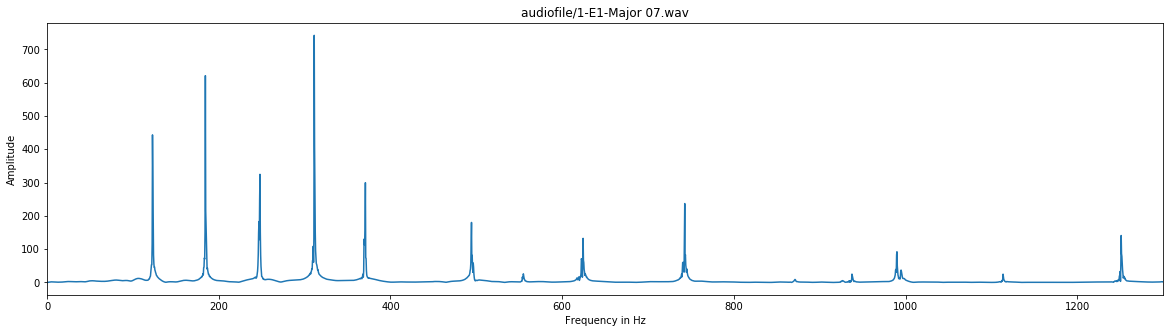

In [11]:
plot_freq_domain(freq1,fourier1, wav_file1)

In [12]:
ampl_const = 200
fourier_list = list(fourier)
ampl_peaks = list(filter(lambda i: i > 200, fourier_list))
ampl_peaks

[374.83989049515975,
 309.669301273104,
 659.4366543974768,
 204.08358340962485,
 670.0260472168677,
 538.5666561505267,
 288.8957144854545,
 245.59015598167906,
 304.8036232528577,
 241.99688784691295,
 214.61956508731078,
 212.50356013688025]

In [13]:
for x in range(len(ampl_peaks)):
    index = fourier_list.index(ampl_peaks[x])
    print('Frequenz bei Index {0}: {1}Hz mit einer Amplitude von: {2:0.2f}dB'
          .format(index, freq[index], ampl_peaks[x]))

Frequenz bei Index 206: 82.4Hz mit einer Amplitude von: 374.84dB
Frequenz bei Index 412: 164.8Hz mit einer Amplitude von: 309.67dB
Frequenz bei Index 413: 165.2Hz mit einer Amplitude von: 659.44dB
Frequenz bei Index 414: 165.6Hz mit einer Amplitude von: 204.08dB
Frequenz bei Index 619: 247.6Hz mit einer Amplitude von: 670.03dB
Frequenz bei Index 620: 248.0Hz mit einer Amplitude von: 538.57dB
Frequenz bei Index 621: 248.4Hz mit einer Amplitude von: 288.90dB
Frequenz bei Index 825: 330.0Hz mit einer Amplitude von: 245.59dB
Frequenz bei Index 827: 330.8Hz mit einer Amplitude von: 304.80dB
Frequenz bei Index 828: 331.2Hz mit einer Amplitude von: 242.00dB
Frequenz bei Index 1033: 413.2Hz mit einer Amplitude von: 214.62dB
Frequenz bei Index 1035: 414.0Hz mit einer Amplitude von: 212.50dB


# Chord Approximation


In [14]:
# Read wav-Files
rate_40, data_40 = wav.read('audiofile/G53-40100-1111-00001.wav')
rate_41, data_41 = wav.read('audiofile/G53-41101-1111-00002.wav')
rate_42, data_42 = wav.read('audiofile/G53-42102-1111-00003.wav')
 
rate_45, data_45 = wav.read('audiofile/G53-45200-1111-00014.wav')
rate_46, data_46 = wav.read('audiofile/G53-46201-1111-00015.wav')
rate_47, data_47 = wav.read('audiofile/G53-47202-1111-00016.wav')
 
rate_50, data_50 = wav.read('audiofile/G53-50300-1111-00027.wav')
rate_51, data_51 = wav.read('audiofile/G53-51301-1111-00028.wav')
rate_52, data_52 = wav.read('audiofile/G53-52302-1111-00029.wav')
 
rate_55, data_55 = wav.read('audiofile/G53-55400-1111-00040.wav')
rate_56, data_56 = wav.read('audiofile/G53-56401-1111-00041.wav')
rate_57, data_57 = wav.read('audiofile/G53-57402-1111-00042.wav')
 
rate_59, data_59 = wav.read('audiofile/G53-59500-1111-00053.wav')
rate_60, data_60 = wav.read('audiofile/G53-60501-1111-00054.wav')
rate_61, data_61 = wav.read('audiofile/G53-61502-1111-00055.wav')
 
rate_64, data_64 = wav.read('audiofile/G53-64600-1111-00066.wav')
rate_65, data_65 = wav.read('audiofile/G53-65601-1111-00067.wav')
rate_66, data_66 = wav.read('audiofile/G53-66602-1111-00068.wav')
 
rate_chord, data_chord = wav.read('audiofile/1-E1-Major 00.wav')


In [15]:
_, mischsignal = fourier_trans(data_chord, rate_chord, 0, 2.5) 
 
# 1. Saite Bund 0 - 2
_, ton_40      = fourier_trans(data_40, rate_40, 0, 2.5)
_, ton_41      = fourier_trans(data_41, rate_41, 0, 2.5)
_, ton_42      = fourier_trans(data_42, rate_42, 0, 2.5)
 
# 2. Saite Bund 0 - 2
_, ton_45      = fourier_trans(data_45, rate_45, 0, 2.5)
_, ton_46      = fourier_trans(data_46, rate_46, 0, 2.5)
_, ton_47      = fourier_trans(data_47, rate_47, 0, 2.5)
 
# 3. Saite Bund 0 - 2
_, ton_50      = fourier_trans(data_50, rate_50, 0, 2.5)
_, ton_51      = fourier_trans(data_51, rate_51, 0, 2.5)
_, ton_52      = fourier_trans(data_52, rate_42, 0, 2.5)
 
# 4. Saite Bund 0 - 2
_, ton_55      = fourier_trans(data_55, rate_55, 0, 2.5)
_, ton_56      = fourier_trans(data_56, rate_56, 0, 2.5)
_, ton_57      = fourier_trans(data_57, rate_57, 0, 2.5)
 
# 5. Saite Bund 0 - 2
_, ton_59      = fourier_trans(data_59, rate_59, 0, 2.5)
_, ton_60      = fourier_trans(data_60, rate_60, 0, 2.5)
_, ton_61      = fourier_trans(data_61, rate_61, 0, 2.5)
 
# 6. Saite Bund 0 - 2
_, ton_64      = fourier_trans(data_64, rate_64, 0, 2.5)
_, ton_65      = fourier_trans(data_65, rate_65, 0, 2.5)
_, ton_66      = fourier_trans(data_66, rate_66, 0, 2.5)


In [16]:
# Build model
m = Model()
 
lamb_40 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_40')
lamb_41 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_41')
lamb_42 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_42')
lamb_45 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_45')
lamb_46 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_46')
lamb_47 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_47')
lamb_50 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_50')
lamb_51 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_51')
lamb_52 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_52')
lamb_55 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_55')
lamb_56 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_56')
lamb_57 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_57')
lamb_59 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_59')
lamb_60 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_60')
lamb_61 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_61')
lamb_64 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_64')
lamb_65 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_65')
lamb_66 = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_66')

NameError: name 'Model' is not defined